### Constant Proportion Portfolio Insurance

In [65]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline
import risk_toolkit as rk
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
ind_return = rk.get_ind_returns()
tmi_return = rk.get_total_market_index_returns()

In [67]:
# Risky assets

risky_r = ind_return['2000':][['Steel', 'Fin', 'Beer']]

# Safe asset
safe_r = pd.DataFrame().reindex_like(risky_r)  # I want a dataframe with safe assets with the same shape as the risky assets defined previously

safe_r[:] = 0.03/12  # I am defining the safe asset as 3% annually and in order to put it in months, I divide by 12

start = 1000  # USD 1,000 portfolio

floor = 0.8

1. Risk budget: Cushion = (Asset value - Floor value)
2. Compute an allocation to safe and risky assets: m * risk budget
3. Recompute the asset value based on the returns
4. For every unit of time

In [68]:
rk.compound(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [69]:
%timeit rk.compound(risky_r)

384 µs ± 8.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [70]:
dates = risky_r.index

n_steps = len(dates)

account_value = start

floor_value = start * floor

m = 3

account_history = pd.DataFrame().reindex_like(risky_r)

cushion_history = pd.DataFrame().reindex_like(risky_r)

risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):

    cushion = (account_value - floor_value) / account_value  # Risk budget

    risky_w = m * cushion

    risky_w = np.minimum(risky_w, 1)  # To limit the weight to 100% and no leverage

    risky_w = np.maximum(risky_w, 0)

    safe_w = 1 - risky_w

    risky_alloc = account_value * risky_w

    safe_alloc = account_value * safe_w

    # Update the account value for this time sstep

    account_value = risky_alloc * (1 + risky_r.iloc[step]) + safe_alloc * (1 + safe_r.iloc[step])

    # Save the values to look at the history and plot it

    cushion_history.iloc[step] = cushion

    risky_w_history.iloc[step] = risky_w

    account_history.iloc[step] = account_value

In [71]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


In [72]:
risky_wealth = start * (1 + risky_r).cumprod()

<AxesSubplot:>

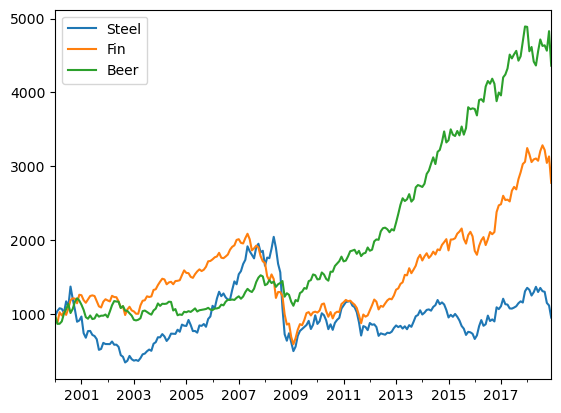

In [73]:
risky_wealth.plot()

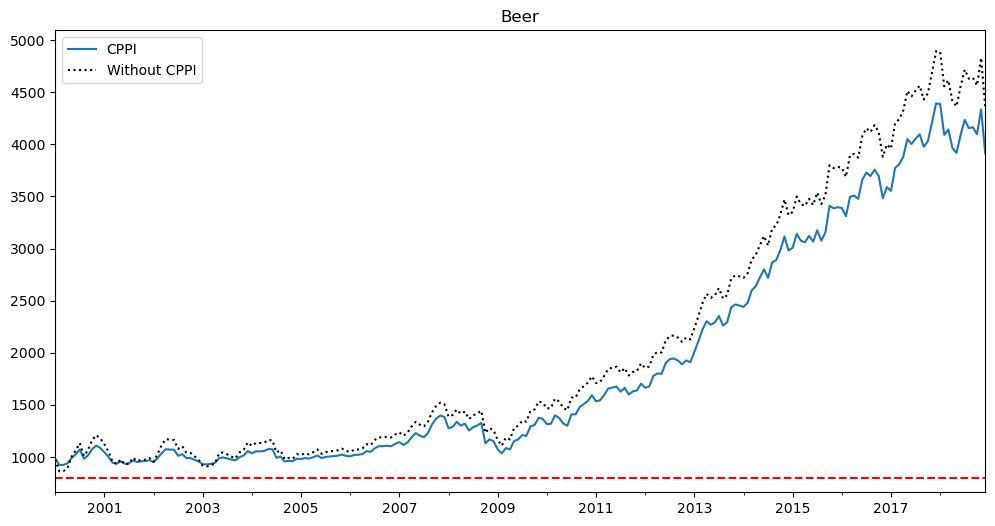

In [74]:
ax = account_history['Beer'].plot(figsize=(12,6), label='CPPI', title='Beer', legend=True)
risky_wealth['Beer'].plot(ax=ax, style='k:', label='Without CPPI', legend=True)
ax.axhline(y=floor_value, color='r', linestyle='--')

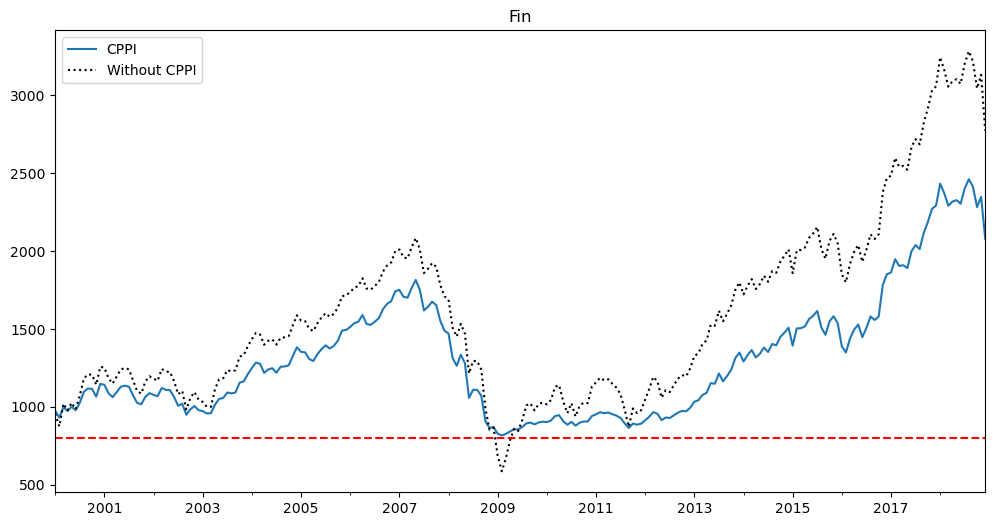

In [75]:
ax = account_history['Fin'].plot(figsize=(12,6), label='CPPI', title='Fin', legend=True)
risky_wealth['Fin'].plot(ax=ax, style='k:', label='Without CPPI', legend=True)
ax.axhline(y=floor_value, color='r', linestyle='--')

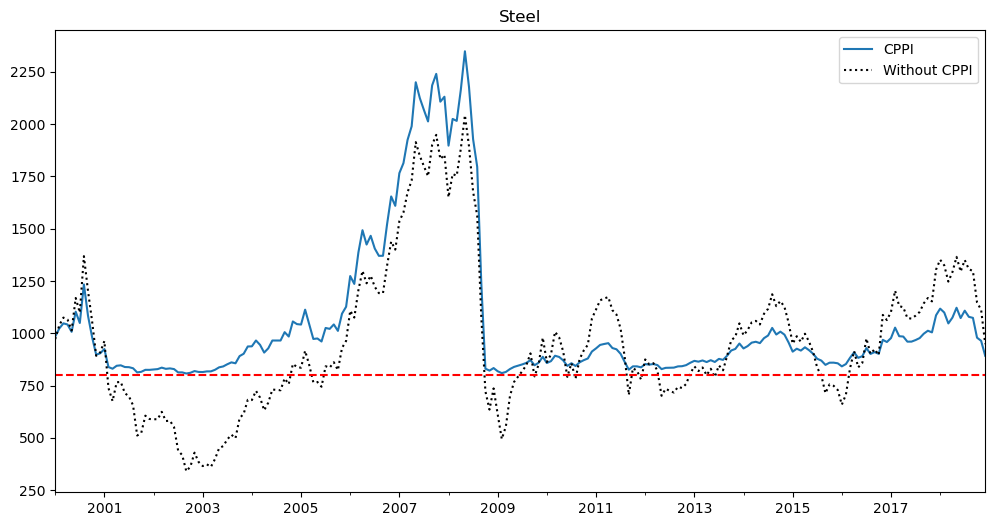

In [76]:
ax = account_history['Steel'].plot(figsize=(12,6), label='CPPI', title='Steel', legend=True)
risky_wealth['Steel'].plot(ax=ax, style='k:', label='Without CPPI', legend=True)
ax.axhline(y=floor_value, color='r', linestyle='--')

In [77]:
rk.summary_stats(risky_r)

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [78]:
btr = rk.run_cppi(risky_r)
rk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


<AxesSubplot:>

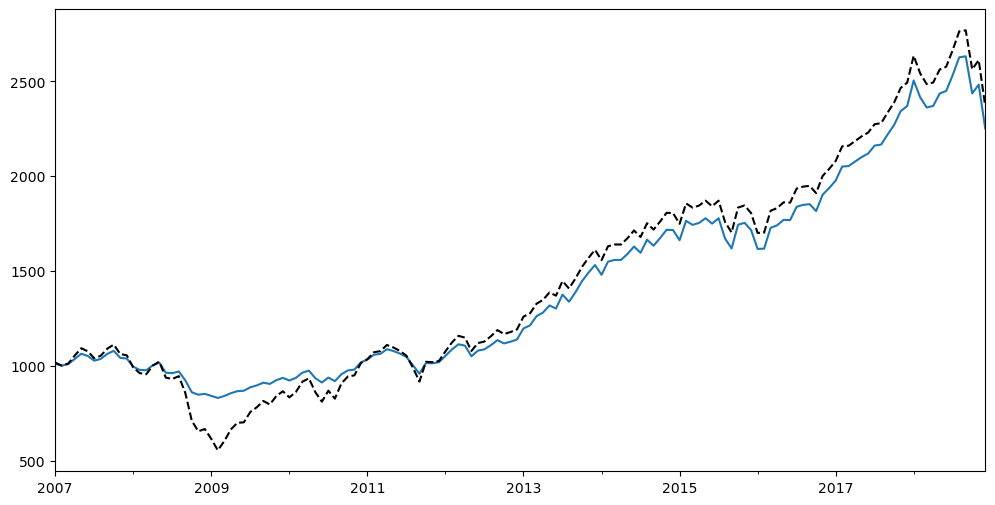

In [80]:
btr = rk.run_cppi(tmi_return['2007':])
ax = btr['Wealth'].plot(figsize=(12,6), legend=False)
btr['Risky Wealth'].plot(ax=ax, style='k--', legend=False)

In [82]:
rk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [83]:
rk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


### Drawdown constraint

In [85]:
btr = rk.run_cppi(ind_return['2007':][['Steel', 'Fin', 'Beer']], drawdown=0.25)

<AxesSubplot:>

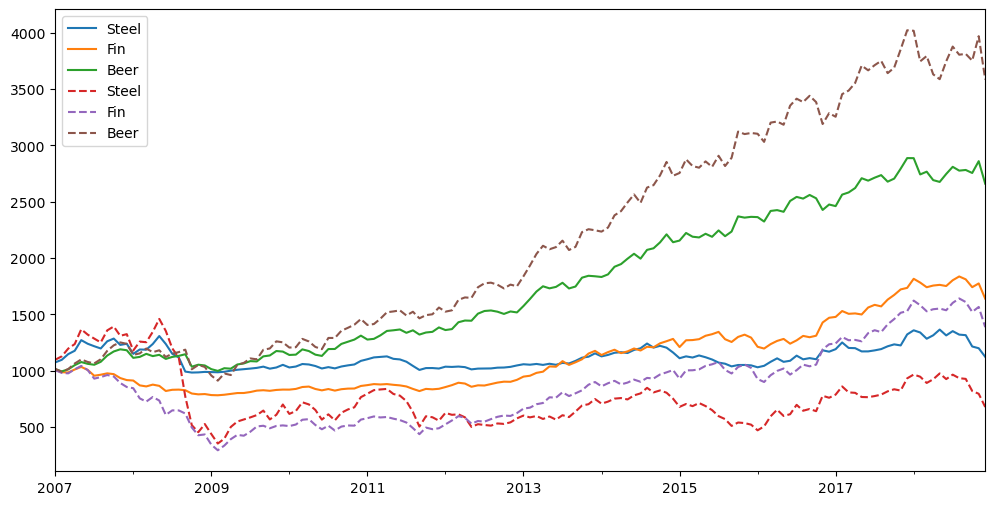

In [86]:
ax = btr['Wealth'].plot(figsize=(12,6))

btr['Risky Wealth'].plot(ax=ax, style='--')

In [87]:
rk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [88]:
rk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186


As evidenced, when we introduce a constraint on how much drawdown are we willing to accept (25%), the CPPI is effective in protecting against higher drawdowns

In [89]:
btr = rk.run_cppi(ind_return['2007':][['Steel', 'Fin', 'Beer']], drawdown=0.02)

<AxesSubplot:>

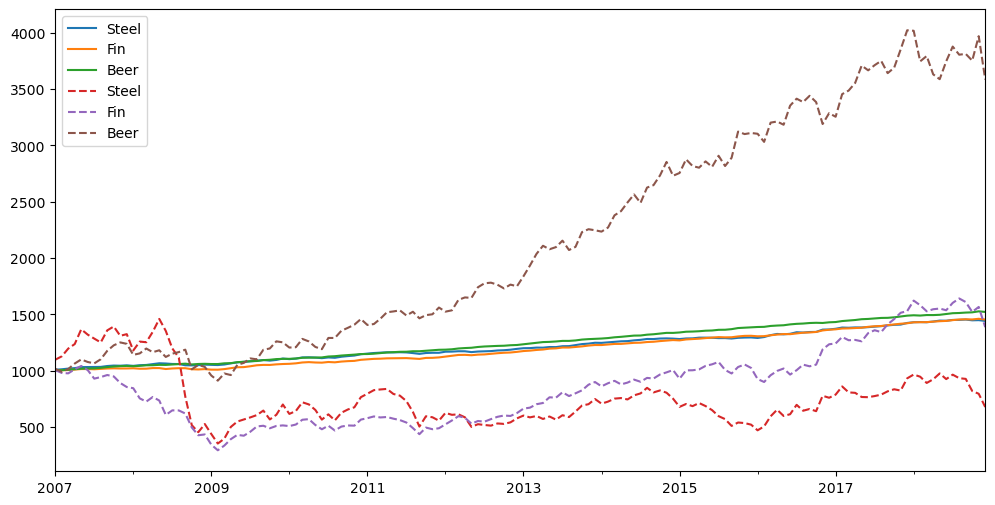

In [90]:
ax = btr['Wealth'].plot(figsize=(12,6))

btr['Risky Wealth'].plot(ax=ax, style='--')

In [91]:
rk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [92]:
rk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.030444,0.014477,0.003177,3.301248,0.004310,0.005897,0.029849,-0.017524
Fin,0.031669,0.011022,-0.733719,4.142413,0.003165,0.004992,0.147406,-0.013919
Beer,0.035545,0.007614,-0.676505,4.723090,0.001012,0.002231,0.708741,-0.006458
